# Inaugural Project - Housing demand and taxation
### Introduction to Programming and Numerical Analysis

**University of Copenhagen, 21 March 2021**

Hand-in by Magnus Bugge, Jens Brøndum Petersen, and Frederik Bach

# Housing demand and taxation

We consider a household looking to buy a home. The household is endowed with an amount of cash-on-hand, $m$, that may spent on housing as well as other consumption $c$. The household derives utility from housing by a measure of its quality, $h$. A home of quality $h$ has the price $ph$ and is subject to progressive taxation and mortgage costs, summarized by the function $\tau(\cdot)$. The objective of the household is therefore to choose optimal amounts of housing and consumption.

**Problem 1 - Household utility maximization** 

The representative household's problem is given by:

$$c^*, h^* = \arg \underset{c,h}{\max} c^{1-\phi}h^\phi \\
                s.t. \\
    \tilde{p}_h = p_h\varepsilon \\
              m = \tau(p_h,\tilde{p}_h)+c \\
\tau(p_h,\tilde{p}_h = rp_h+\tau^h\tilde{p}_h+\tau^p\max\{\tilde{p}_h-\bar{p},0\}$$ 

We take as given the default parameters: 
$\phi = 0.3, \varepsilon = 0.5, r = 0.03, \tau^g = 0.012, \tau^g = 0.004, 
\bar{p} = 3$

The parameters are defined in the dictionary 'parameters' in the code section below.

In [45]:
# import numpy for array operations and the scipy optimize module for optimization
import numpy as np
from scipy import optimize

# create a dictionary containing the parameters given
parameters = {'phi': 0.3, 'eps': 0.5, 'r': 0.03, 'tau_g': 0.012, 
              'tau_p': 0.004, 'p_bar': 3, 'm': 0.5}

Now, we construct the utility function along with the maximization constraints as individual functions:

In [46]:
def utility_function(c, h, parameters):
    """ Defines utility function based on consumption bundle and parameters        
    
    Args:
        c (float): amount of consumption in non-housing goods 
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        u (float): utility        
    """

    u = c**(1-parameters['phi']) * h**parameters['phi']
    return u


def taxes_paid(h, parameters):
    """ Calculates the cash amount of taxes paid by the individual household given the choice of house quality      
    
    Args:
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        taxes (float): cash amount of taxes paid
    """
    
    taxes = parameters['r'] * h + parameters['tau_g'] * h * parameters['eps'] + parameters['tau_p'] * max(h * parameters['eps'] - parameters['p_bar'], 0)
    return taxes
    
    
def budget_constraint(h, parameters):
    """ Defines the budget constraint of the household, which says that consumption is equal to the cash-on-hand minus tax expenditure   
    
    Args:
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        c (float): the upper limit (budget constraint) for consumption in non-housing goods
    """ 
    
    c = parameters['m'] - taxes_paid(h, parameters)
    return c

Now, we define the objective function and maximize it wrt. c and h

In [47]:
# objective function (we maximize it by minimizing the negative utility function)
def value_of_choice(h, parameters):
    """ Defines the objective function to be optimized
    
    Args:
        h (float): housing consumption
        parameters (dict): dictionary of parameters wrt. policy and preferences
        
    Returns:
        -utility_function (float): the negative of the implied utility from consumption c and h
    """ 

    c = budget_constraint(h, parameters)
    return -utility_function(c, h, parameters)


# use the optimizer from the scipy package to optimize value_of_choice
solution = optimize.minimize_scalar(
    value_of_choice, bounds = None, args = (parameters))


# save the optimal consumption bundle and the implied utility the variables h, c, and u
h = solution.x
c = budget_constraint(h, parameters)
u = utility_function(c, h, parameters)

# print the solution
print(h)
print(c)
print(u)

4.1666666039527485
0.35000000225770106
0.7358414678061572


**Problem 2 - Plot of c* and h* as functions of m in the range 0.4 to 1.5** 

In [56]:
# import the pandas package for dataframe
import pandas as pd

# define a range of endowments, m, to be iterated over
m_range = np.arange(0.4, 1.5, 0.01).tolist()

# initialize an empty array
solutions = []

# use the optimization algorithm from problem 1 for all m's in m_range
for m in m_range:
    parameters['m'] = m
    solution = optimize.minimize_scalar(
    value_of_choice, bounds = None, args = (parameters))
    h = solution.x
    c = budget_constraint(h, parameters)
    solutions.append([m, h, c])

# save the solutions in a pandas dataframe and print it
solutions = pd.DataFrame(solutions, columns=["m", "h", "c"])
#print(solutions)

        m          h       c
0    0.40   3.333333  0.2800
1    0.41   3.416667  0.2870
2    0.42   3.500000  0.2940
3    0.43   3.583333  0.3010
4    0.44   3.666667  0.3080
..    ...        ...     ...
105  1.45  11.542105  1.0234
106  1.46  11.621053  1.0304
107  1.47  11.700000  1.0374
108  1.48  11.778948  1.0444
109  1.49  11.857895  1.0514

[110 rows x 3 columns]


Now, after obtaining a dataframe of 110 solutions to the household's problem, we plot it using the matplotlib package

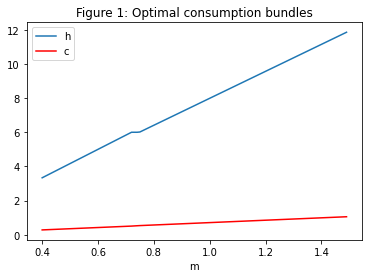

In [59]:
# import the matplotlib pyplot module package for the plot
import matplotlib.pyplot as plt

# plot the solution dataframe
m_axis = plt.gca()
solutions.plot(x = 'm', y = 'h', ax = m_axis, title = 'Figure 1: Optimal consumption bundles');
solutions.plot(x = 'm', y = 'c', ax = m_axis, color = 'red');

From figure 1, we see that the consumption bundle is increasing in both goods for increasing endowments, which is a result of the monotonous utility function.

What is interesting here is that around the endowment m = 0.72, the households begin buying houses that are taxed in the higher tax bracket. Initially,

this causes the households to being reluctant on buying more expensive houses, since the marginal utility on consumption is higher. However, when the 

endowment reaches a certain point, the households again begin buying more and more expensive houses.

**Problem 3 - Average tax burden** 

Here, we calculate the average tax burden among 10,000 households assuming that cash endowments follow a log-normal distribution.

In [75]:
# set the number of households and the seed number
N = 10000
seed = 420

# draw list of 10,000 cash endowments from the lognormal distributions
np.random.seed(seed)
m_sim = np.random.lognormal(mean=-0.4,sigma=0.35,size=N).tolist()

# initialize an empty array
solutions_sim = []

# use the optimization algorithm from problem 1 for all 10,000 m's in m_sim
for m in m_sim:
    parameters['m'] = m
    sol_case1 = optimize.minimize_scalar(
    value_of_choice, bounds = None, args = (parameters))
    h = sol_case1.x
    c = budget_constraint(h, parameters)
    solutions_sim.append(h)

# calculate the average tax burden as t = T/N, where T is the total tax payment and N is the number of households
T = 0
for h in solutions_sim:
    # for each iteration, calculate one household's tax burden
    T+=parameters['tau_g']*h + parameters['tau_p'] * max(h-parameters['p_bar'], 0) 
t = T/N
print(t)

0.08068501885378469


Now, we plot the distributions of h and c given the simulations of the cash endowment.

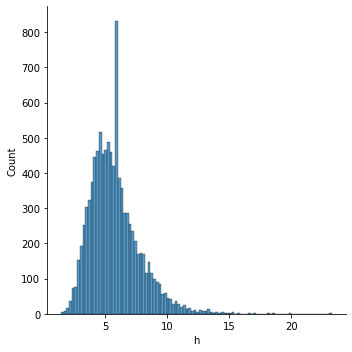

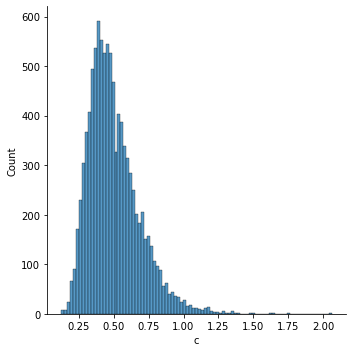

In [80]:
# Plot of distributions
import seaborn as sns

solutions = []

for m in mer:
    parameters['m'] = m
    sol_case1 = optimize.minimize_scalar(
    value_of_choice, bounds = None, args = (parameters))
    h = sol_case1.x
    c = budget_constraint(h, parameters)
    solutions.append([m, h, c])

solutions = pd.DataFrame(solutions, columns=["m", "h", "c"])

sns.displot(solutions, x="h")
sns.displot(solutions, x="c")

What is interesting from the plots above is the skewness of the distributions. This seems to be due to the tax schedule which has two tax brackets. That is, households 

are taxes differently depending on the public assessment of their house. As we also saw in problem 2, households stop buying more expensive houses when reaching the

endowment region of rougly m = 0.72. Therefore, there is an outlier of households who buy houses of the approximate value of h = 6.

**Problem 4 - Tax reform** 

Now, the government imposes a tax reform which alternates some of the given parameters. We implement the new parameters by creating a new dictionary.

In [85]:
# Create a dictionary containing the new parameters
parameters_reform = {'phi': 0.3, 'eps': 0.8, 'r': 0.03, 'tau_g': 0.01, 
              'tau_p': 0.009, 'p_bar': 8, 'm': 0.5}

solutions_reform_sim = []

for m in m_sim:
    parameters_reform['m'] = m
    solution = optimize.minimize_scalar(
    value_of_choice, bounds = None, args = (parameters_reform))
    h = solution.x
    c = budget_constraint(h, parameters_reform)
    solutions_reform_sim.append(h)

T_reform = 0
for h in solutions_reform_sim:
    T_reform+=parameters_reform['tau_g']*h + parameters_reform['tau_p']*max(h-parameters_reform['p_bar'], 0)

t_reform = T_reform / N
print(t_reform)

0.05711861105539854


We see from t_reform that the average tax burden has decreased from 0.08 to 0.06.

**Problem 5 - tax reform pt. 2**

Now, the government wants to re-engineer the tax reform, such that the average tax burden is unchanged between the tax schedules. They want to do this by imposing the new parameters, while lowering $\tau_g$, so the tax effects are offset. 

In [102]:
taug_list = np.arange(0, 0.019, 0.001).tolist()
parameters_reform_new = {'phi': 0.3, 'eps': 0.8, 'r': 0.03, 'tau_g': 0.012, 'tau_p': 0.009, 'p_bar': 8, 'm': 0.5}

N_new = 10000
seed = 420

np.random.seed(seed)

#Making an iterator variable, for tracking which iteration is running.
iterator = 1

#Generating new list of the m variable
m_sim_new = np.random.lognormal(mean=-0.4,sigma=0.35,size=N_new).tolist()

#Creating a pandas dataframe to store lists of h for different values of tau_g
df = pd.DataFrame()

#Running a loop for all the tau_g's in the tau_g list
for tau_g in taug_list:
    
    #starting out with an empty array
    solutions_reform_new = []

    #changing the value of tau_g in the dictionary of parameters
    parameters_reform_new['tau_g'] = tau_g
    
    #running a new for loop for the different values of m
    for m in m_sim_new:
        
        #changing the values of m in the dictionary of parameters
        parameters_reform_new['m'] = m
        
        solution = optimize.minimize_scalar(
            value_of_choice, bounds = None, args = (parameters_reform_new))
        h = solution.x
        c = budget_constraint(h, parameters_reform_new)
        solutions_reform_new.append(h)
    
    #After each iteration of the 2nd for loop the generated array of h is included in in the previously generated pandas dataframe, it is important that the solutions_nytest is emptied within the for-loop as seen above
    df['h_' + str(iterator)] = solutions_reform_new
    
    #Reseting the T variable as the sum of T is done several times.
    T = 0
    #Running a new for-loop, still within the first, as different versions of tau_g is used. The iloc function is used in the for-loop with the iterator variable as the column index, reflecting which column of the pandas dataframe is used.
    for h in df.iloc[:,iterator-1]:
        T+=parameters_reform_new['tau_g']*h + parameters_reform_new['tau_p']*max(h-parameters_reform_new['p_bar'], 0)
    print(f'for tau_g = {tau_g:3f}, t =  {T/N:4f}')
    iterator +=1

for tau_g = 0.000000, t =  0.004453
for tau_g = 0.001000, t =  0.010767
for tau_g = 0.002000, t =  0.016819
for tau_g = 0.003000, t =  0.022620
for tau_g = 0.004000, t =  0.028177
for tau_g = 0.005000, t =  0.033506
for tau_g = 0.006000, t =  0.038621
for tau_g = 0.007000, t =  0.043528
for tau_g = 0.008000, t =  0.048238
for tau_g = 0.009000, t =  0.052765
for tau_g = 0.010000, t =  0.057119
for tau_g = 0.011000, t =  0.061311
for tau_g = 0.012000, t =  0.065345
for tau_g = 0.013000, t =  0.069233
for tau_g = 0.014000, t =  0.072981
for tau_g = 0.015000, t =  0.076594
for tau_g = 0.016000, t =  0.080079
for tau_g = 0.017000, t =  0.083441
for tau_g = 0.018000, t =  0.086688


Thus, for $\tau_g=0.018$, the government obtains an unchanged average tax burden under the new tax schedule.